interactive(children=(IntSlider(value=0, description='start_index', max=253), IntSlider(value=253, description…

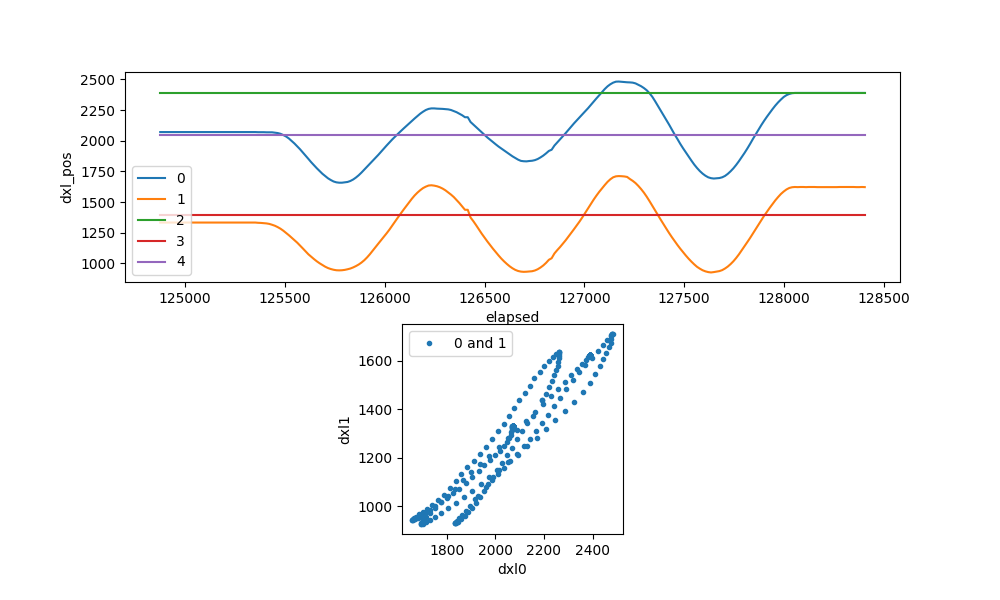

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import trim_mean
import glob
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
%matplotlib widget

list_of_files = [f for f in glob.glob('./traj/*') if not os.path.isdir(f)] #take all files but not folders
latest_file = max(list_of_files, key=os.path.getctime)

file_path = latest_file
# file_path = "./data/0500um_110mm_c1_2023-12-15_20-56-08.txt"

# Read the text file into a list of lines
with open(file_path, 'r') as file:
    lines = file.readlines()

labels = ['elapsed', 'dxl_pos[0]', 'dxl_pos[1]', 'dxl_pos[2]', 'dxl_pos[3]', 'dxl_pos[4]',]
data_dict = {}
for label in labels:
    data_dict[label] = []

for line in lines:
    for label in labels:
        if(line.startswith(label)):
            data_dict[label].append(float(line.split(':')[1]))
    if line.startswith('end'): 
        break

# Create a dataframe from the extracted values
df_raw = pd.DataFrame(data_dict)
df = None #cropped version

plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(10,6))
@interact(start_index=IntSlider(min=0, max=len(df_raw)-1, step=1, value=0),
          end_index=IntSlider(min=0, max=len(df_raw)-1, step=1, value=len(df_raw)-1))
def display_image(start_index, end_index):
    if(start_index >= end_index):
        return

    global df
    df = df_raw[start_index:end_index]
    
    axs[0].clear()
    axs[0].set_xlabel('elapsed')
    axs[0].set_ylabel('dxl_pos')
    for i in range(5):
        axs[0].plot(df['elapsed'], df[f'dxl_pos[{i}]'], label=f'{i}')
    axs[0].legend()

    axs[1].clear()
    axs[1].set_xlabel('dxl0')
    axs[1].set_ylabel('dxl1')
    axs[1].plot(df['dxl_pos[0]'], df['dxl_pos[1]'], '.', label=f'0 and 1')
    axs[1].legend()
    axs[1].set_aspect('equal', adjustable='box')
plt.show()

In [3]:
traj_df = df.copy().reset_index(drop=True) #index from 0, dont put the old index as a new column
traj_df['elapsed'] = traj_df['elapsed']-traj_df['elapsed'][0]

traj_df.to_csv(f"{file_path[:-4]}.csv", index=False) #write to csv with same name, don't have index as column 
traj_df

,elapsed,dxl_pos[0],dxl_pos[1],dxl_pos[2],dxl_pos[3],dxl_pos[4]
0,0.0,2422.0,1639.0,2391.0,1396.0,2047.0
1,14.0,2444.0,1665.0,2391.0,1396.0,2047.0
2,28.0,2461.0,1686.0,2391.0,1396.0,2047.0
3,42.0,2474.0,1702.0,2391.0,1396.0,2047.0
4,56.0,2482.0,1710.0,2391.0,1396.0,2047.0
...,...,...,...,...,...,...
68,952.0,2390.0,1623.0,2391.0,1396.0,2047.0
69,966.0,2390.0,1622.0,2391.0,1396.0,2047.0
70,980.0,2390.0,1623.0,2391.0,1396.0,2047.0
71,994.0,2390.0,1623.0,2391.0,1396.0,2047.0


1760.0


,elapsed,dxl_pos[0],dxl_pos[1],phase
0,0.0,1254.000000,1167.000000,0.000000
1,10.0,1241.869318,1177.397727,0.005682
2,20.0,1229.738636,1187.795455,0.011364
3,30.0,1217.926136,1198.073864,0.017045
4,40.0,1208.568182,1207.431818,0.022727
...,...,...,...,...
95,950.0,2758.704545,1765.625000,0.539773
96,960.0,2748.909091,1755.000000,0.545455
97,970.0,2736.085227,1743.562500,0.551136
98,980.0,2723.261364,1732.125000,0.556818


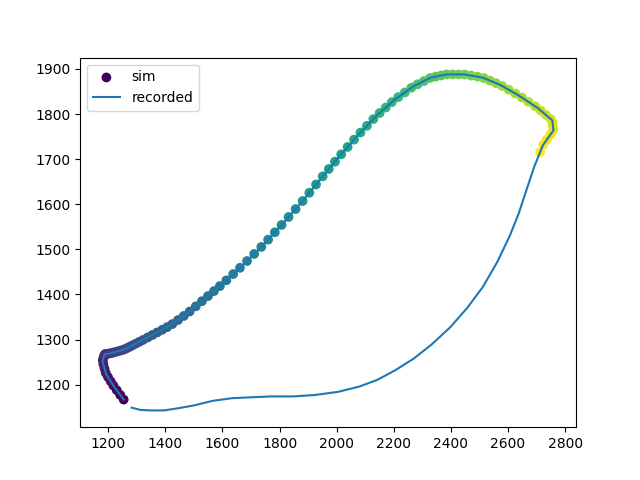

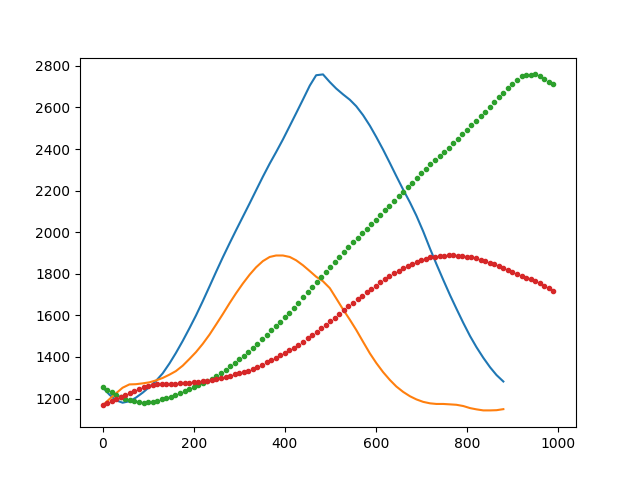

In [6]:
#simulate traj follow
elapseds = np.arange(0, 1000, 10)
speed = 0.5
period = traj_df['elapsed'][len(traj_df)-1]/speed
# period = 150

print(period)
follow_df = pd.DataFrame({'elapsed': [], 'dxl_pos[0]': [], 'dxl_pos[1]': [], 'phase': []})
for elapsed in elapseds:
    phase = elapsed/period
    progress = (phase - int(phase)) * len(traj_df) #goes from 0 to length of traj
    index = int(progress)
    index_frac = progress - index

    if(index + 1 < len(traj_df)):
        index_next = index + 1
    else:
        index_next = 0
    
    follow_df.loc[len(follow_df)] = [
        elapsed, 
        (1-index_frac)*traj_df['dxl_pos[0]'][index] + (index_frac)*traj_df['dxl_pos[0]'][index_next], 
        (1-index_frac)*traj_df['dxl_pos[1]'][index] + (index_frac)*traj_df['dxl_pos[1]'][index_next], 
        phase
    ]

plt.figure()
plt.scatter(follow_df['dxl_pos[0]'], follow_df['dxl_pos[1]'], c=follow_df['elapsed'],  label=f'sim')
plt.plot(traj_df['dxl_pos[0]'], traj_df['dxl_pos[1]'], '-', label=f'recorded')
plt.legend()

plt.figure()
plt.plot(traj_df['elapsed'], traj_df['dxl_pos[0]'], '-')
plt.plot(traj_df['elapsed'], traj_df['dxl_pos[1]'], '-')
plt.plot(follow_df['elapsed'], follow_df['dxl_pos[0]'], '.')
plt.plot(follow_df['elapsed'], follow_df['dxl_pos[1]'], '.')

follow_df

In [145]:
plt.close('all')